In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pompy import models
from pompy import processors
from matplotlib.ticker import FormatStrFormatter
import time

#### Background  

Flies and other insects have been observed to use a ["cast and surge"](https://www.sciencedirect.com/science/article/pii/S0960982213015820) behavior to chase an odor plume to its source . 

To understand and simulate plume-tracking behavior, it is useful to have an efficient method to compute the odor experienced by a swarm of flies as they move through the odor produced by time-evolving odor plumes.

We borrow [Matt Graham's time-evolving plume simulation](https://github.com/InsectRobotics/pompy), which uses the puff-based plume approximation developed by [Farrell et al 2002](https://link.springer.com/article/10.1023/A:1016283702837).


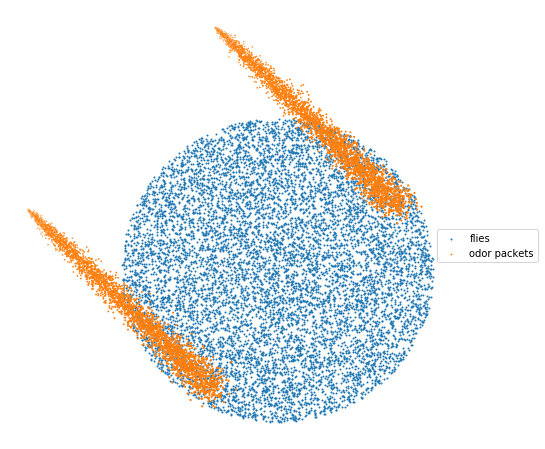

In [37]:
#constants
num_flies = 10000
arena_size = 1000
run_time = 5 #min

#Here we have the original implementation and show the time it takes
xlim = (-arena_size, arena_size)
ylim = (-arena_size, arena_size)
sim_region = models.Rectangle(xlim[0],  ylim[0], ylim[1], xlim[1])
wind_region = models.Rectangle(xlim[0],  ylim[0],  xlim[1], ylim[1])
wind_mag = 1.4


#wind model setup
diff_eq = True
aspect_ratio= (xlim[1]-xlim[0])/(ylim[1]-ylim[0])
noise_gain=3.
noise_damp=0.071
noise_bandwidth=0.71
wind_grid_density = 200
constant_wind_angle = 7*np.pi/4.
wind_field = models.WindModel(wind_region,int(wind_grid_density*aspect_ratio),
    wind_grid_density,noise_gain=noise_gain,noise_damp=noise_damp,
    noise_bandwidth=noise_bandwidth,\
                              angle=constant_wind_angle,mag=wind_mag)


plume_width_factor = 4
centre_rel_diff_scale = 2.*plume_width_factor
# puff_release_rate = 0.001
puff_release_rate = 10
puff_spread_rate=0.005
puff_init_rad = 0.01
max_num_puffs=int(2e5)
# max_num_puffs=100
source_pos = np.array([[0,700],[300,1000]]).T
plume_dt = 0.25

plumes = models.PlumeModel(
sim_region, source_pos, wind_field, run_time*60, plume_dt, centre_rel_diff_scale=centre_rel_diff_scale, \
puff_release_rate=puff_release_rate, \
puff_init_rad=puff_init_rad,puff_spread_rate=puff_spread_rate, \
max_num_puffs=max_num_puffs)

#Run the plumes for a while to create enough puffs
for j in range(int(run_time*60/plume_dt)):
    plumes.update(plume_dt)

#make an array of fly locations
#target_locs = np.random.uniform(0.,arena_size,(num_flies,2)) #shape num_flies x 2

rs = (arena_size/4)*np.sqrt(np.random.uniform(0, 1,size=num_flies))
angles = np.pi * np.random.uniform(0, 2,size=num_flies)

x = rs * np.cos(angles) + 400
y = rs * np.sin(angles) + 600

target_locs = np.vstack((x,y)).T

puff_array = plumes.puff_array


plt.figure(figsize=(8,8))
ax = plt.subplot()
plt.scatter(target_locs[:,0], target_locs[:,1],label='flies',s=1)#,c=conc_vals)
plt.scatter(puff_array[:,:,0],puff_array[:,:,1],label='odor packets',s=puff_array[:,:,3])
plt.axis('off')
plt.legend(loc=1,bbox_to_anchor=(1.2,0.5))
plt.show()

Say we have $N$ fly locations, and for each fly-location, we want to compute the experienced odor concentration, which is the sum of the values of $M$ 2D Gaussian concentration distributions.

#### Speedup with Grid Approximation

In [Matt's original implementation](https://github.com/annierak/fly_pompy/blob/3d0211701de18488c29214816bb8c9e1e12b8812/pompy/processors.py#L17), this computation takes order $M*N$, which grows slow with a large ensemble of flies. We can use a grid-based method (inspired from the techniques used [here] (https://epubs.siam.org/doi/abs/10.1137/0912004) to speed up the fly-odor computation to order $M+N$ (implementation [here](https://github.com/annierak/fly_pompy/blob/3d0211701de18488c29214816bb8c9e1e12b8812/pompy/processors.py#L116)). 

The rough idea is split space into a grid, and to sum for each fly the contributions only from the puffs that are in grid boxes near the fly*.

In [4]:
r_sq_max=20;epsilon=0.00001;N=1e6;box_min=-1*arena_size;box_max = arena_size;puff_mol_amt=1.

odor_field = processors.ConcentrationValueCalculator(puff_mol_amt) 
odor_field1 = processors.ConcentrationValueFastCalculator(box_min,box_max,r_sq_max,epsilon,puff_mol_amt,N)

In [5]:
last = time.time()
conc_vals = odor_field.calc_conc_list(
                puff_array, target_locs[:,0], target_locs[:,1])
print('old method takes '+str(time.time()-last)[0:5]+' seconds')

last = time.time()
conc_vals1 = odor_field1.calc_conc_list(
                puff_array, target_locs[:,0], target_locs[:,1])
print('new method takes '+str(time.time()-last)[0:5]+' seconds')


old method takes 1.294 seconds
new method takes 0.113 seconds


Yay! 10x speed increase. 

Now let's check that the values computed are preserved between the old and the new algorithm. An easy way to do this is to plot the values against each other to make sure they line up on the unity line.

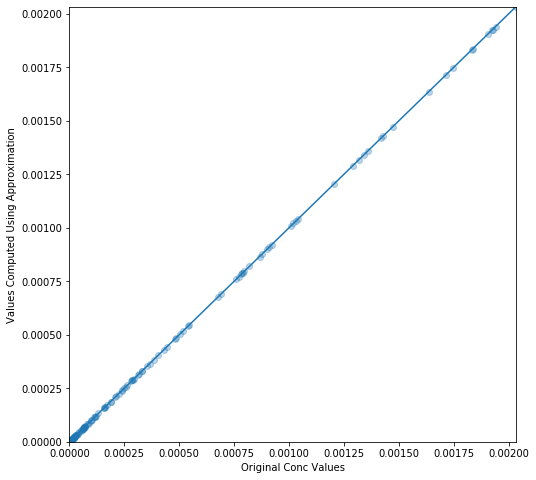

In [42]:
plt.figure(figsize=(8,8))
ax = plt.subplot()
plt.scatter(conc_vals, conc_vals1,alpha=0.3)
xmax = np.percentile(conc_vals1,99)
plt.plot(np.linspace(0,xmax,100),np.linspace(0,xmax,100))
ax.set_xlim(0,xmax)
ax.set_ylim(0,xmax)
plt.xlabel('Original Conc Values')
plt.ylabel('Values Computed Using Approximation')
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.show()

**Theory of the Approximation**

We borrow from some of the techniques discussed [here](https://epubs.siam.org/doi/abs/10.1137/0912004) to implement the approximation.  

Instead of computing the concentration for every target for every source (order $M*N$): 

Form a grid of width $d$ on the 2D space.

Assign each target to its box.

Assign each source to its box.

Loop through each box: For every target in the box, sum the contributions from each source in that box AND in the 
eight surrounding boxes.

How small should $d$ be? Small enough that in the worst cast scenario, if all the sources ($<M$) that were not within those 9 boxes, were all right against the edge so that they were $d$ away from a given target, the summed contribution of those not-counted sources would be insignificant, or less than a desired $\epsilon$.

[comment]: <> (formula for above --> show the conversion of computing d from epsilon)